In [1]:
import findspark
findspark.init()

In [2]:
#Importing libraries
import pyspark.sql.functions as f
from pyspark.sql.functions import col, lit
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("machinelearning").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/29 20:16:22 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
22/04/29 20:16:33 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Attempted to request executors before the AM has registered!


In [4]:
#Checking the status of spark session
spark

### Reading the dataset from s3

In [7]:
df_full = spark.read.parquet('s3://ssp88-labdata2/eda_df_full')

In [8]:
df_full.printSchema()

root
 |-- all_awardings: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_created_utc: double (nullable = true)
 |-- author_flair_richtext: string (nullable = true)
 |-- author_flair_type: string (nullable = true)
 |-- author_fullname: string (nullable = true)
 |-- author_patreon_flair: boolean (nullable = true)
 |-- author_premium: boolean (nullable = true)
 |-- awarders: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- can_mod_post: boolean (nullable = true)
 |-- collapsed: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- gildings: string (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- locked: boolean (nullable = true)
 |-- no_follow: boolean (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- p

In [9]:
#Checking the length of the comment 
df_full = df_full.withColumn("comment_length", f.length(col('body')))

### Question 1 : Predict Score of the comment

In [188]:
#Selecting necessary columns
df_score = df_sentiment.select(['sentiment', 'controversiality','total_awards_received','comment_length','hour', 'score'] )

In [189]:
df_score.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- total_awards_received: long (nullable = true)
 |-- comment_length: integer (nullable = true)
 |-- hour: string (nullable = true)
 |-- score: long (nullable = true)



#### ML Tranformations

In [92]:
df_score.groupBy('sentiment').count().show()

+---------+-------+
|sentiment|  count|
+---------+-------+
| positive|9880051|
|     null| 108800|
|  neutral| 968815|
| negative|7163286|
+---------+-------+



In [93]:
#Keeping the rows with only True, False as author_premium
df_score = df_score.filter((df_score.sentiment == 'positive') | (df_score.sentiment == 'neutral') | (df_score.sentiment == 'negative'))

In [56]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import roc_curve, roc_auc_score
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [174]:
#Splitting the data into train test and predict for our creating the model
train_data, test_data = df_score.randomSplit([0.8, 0.2], 24)

In [175]:
stringIndexer_sentiment = StringIndexer(inputCol="sentiment", outputCol="sentiment_idx")
stringIndexer_hour = StringIndexer(inputCol="hour", outputCol="hour_idx")

In [176]:
onehot_sentiment = OneHotEncoder(inputCol="sentiment_idx", 
                       outputCol="sentiment_vec")
onehot_hour = OneHotEncoder(inputCol="hour_idx", 
                       outputCol="hour_vec")

In [177]:
vectorAssembler_sentiment = VectorAssembler(
    inputCols=['sentiment_vec', 'controversiality','total_awards_received','comment_length','hour_vec'],
    outputCol= "features")

#### Linear Regression

In [179]:
# Create initial LinearRegression model
lr1 = LinearRegression(labelCol="score", featuresCol="features")

In [180]:
#Creating a pipeline
pipeline_lr1 = Pipeline(stages=[stringIndexer_sentiment, stringIndexer_hour, onehot_sentiment, onehot_hour, vectorAssembler_sentiment, lr1])

In [182]:
# Create ParamGrid for Cross Validation
lrparamGrid2 = ParamGridBuilder()\
             .addGrid(lr1.regParam, [1,2, 3])\
             .addGrid(lr1.elasticNetParam, [0.25, 0.5, 0.75])\
             .addGrid(lr1.maxIter, [5, 10, 20])\
             .build()

In [183]:
# Evaluate model
lrevaluator1 = RegressionEvaluator(predictionCol="prediction", labelCol="score", metricName="rmse").setLabelCol("score")

In [184]:
# Create 3-fold CrossValidator
lrcv1 = CrossValidator(estimator = pipeline_lr1,
                    estimatorParamMaps = lrparamGrid1,
                    evaluator = lrevaluator1,
                    numFolds = 3)

In [185]:
# Run cross validations
lrcvModel1 = lrcv1.fit(train_data)

22/04/29 23:11:47 WARN Instrumentation: [c9cb094b] regParam is zero, which might cause numerical instability and overfitting.
22/04/29 23:11:50 WARN Instrumentation: [c9cb094b] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
22/04/29 23:12:03 WARN Instrumentation: [485fa21e] regParam is zero, which might cause numerical instability and overfitting.
22/04/29 23:12:05 WARN Instrumentation: [485fa21e] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
22/04/29 23:12:08 WARN Instrumentation: [190b2e7b] regParam is zero, which might cause numerical instability and overfitting.
22/04/29 23:12:10 WARN Instrumentation: [190b2e7b] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
22/04/29 23:12:14 WARN Instrumentation: [9dfe5eac] regParam is zero, which might cause numerical instability and overfitting.
22/04/29 23:12:16 WARN Instrumentation: [9dfe5eac] Cholesky solv

In [117]:
# Save the model pipeline into s3
lrcvModel1.write().save('s3://ssp88-labdata2/lrcvModel1.1')

In [186]:
# Use test set here so we can measure the accuracy of our model on new data
lrprediction1 = lrcvModel1.transform(test_data)

In [141]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('MSE:',lrevaluator1.evaluate(lrprediction1,
{lrevaluator1.metricName: "mse"})
)
print('RMSE:', lrevaluator1.evaluate(lrprediction1,
{lrevaluator1.metricName: "rmse"})
)
print('MAE:',lrevaluator1.evaluate(lrprediction1,
{lrevaluator1.metricName: "mae"})
)

MSE: 32234.198698835175


RMSE: 179.53885011003933


MAE: 22.33287317693236


In [143]:
# Original and Predicted data
x_ax = range(0, lrprediction1.count())
y_pred = lrprediction1.select("prediction").collect()
y_orig = lrprediction1.select("score").collect()  

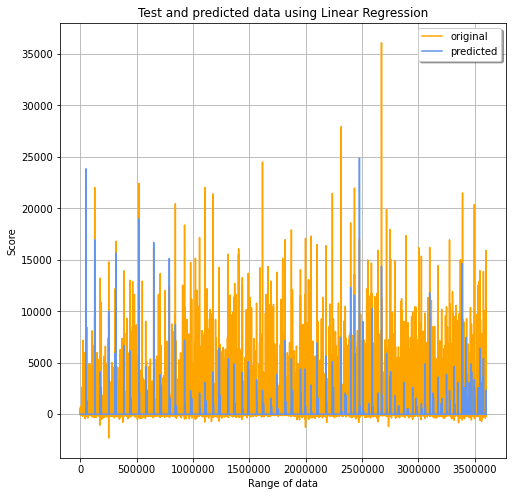

In [153]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(x_ax, y_orig,'orange', label="original")
plt.plot(x_ax, y_pred,'cornflowerblue' ,label="predicted")
plt.title("Test and predicted data using Linear Regression")
plt.xlabel('Range of data')
plt.ylabel('Score')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.ticklabel_format(style='plain',useOffset=False) 
plt.grid(True)
plt.show()  
 

#### Decision Tree Regression

In [121]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [122]:
dt = DecisionTreeRegressor(labelCol="score", featuresCol="features")

In [124]:
#Creating a pipeline
pipeline_dt = Pipeline(stages=[stringIndexer_sentiment, stringIndexer_hour, onehot_sentiment, onehot_hour, vectorAssembler_sentiment, dt])

In [125]:
# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()\
             .addGrid(dt.maxDepth, [2, 5, 10])\
             .addGrid(dt.maxBins, [10, 20,40])\
             .build())

In [126]:
# Evaluate model
dtevaluator = RegressionEvaluator(predictionCol="prediction", labelCol="score", metricName="rmse")

In [127]:
# Create 3-fold CrossValidator
dtcv = CrossValidator(estimator = pipeline_dt,
                      estimatorParamMaps = dtparamGrid,
                      evaluator = dtevaluator,
                      numFolds = 3)

In [128]:
# Run cross validations
dtcvModel = dtcv.fit(train_data)

In [ ]:
# Save the model pipeline into s3
dtcvModel.write().save('s3://ssp88-labdata2/dtcvModel')

In [129]:
# Use test set here so we can measure the accuracy of our model on new data
dtpredictions = dtcvModel.transform(test_data)

In [140]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('MSE:',dtevaluator.evaluate(dtpredictions,
{dtevaluator.metricName: "mse"})
)
print('RMSE:', dtevaluator.evaluate(dtpredictions,
{dtevaluator.metricName: "rmse"})
)
print('MAE:',dtevaluator.evaluate(dtpredictions,
{dtevaluator.metricName: "mae"})
)

MSE: 30039.488938120427


RMSE: 173.3190380140636


MAE: 21.004838989749768


In [155]:
# Original and Predicted data
x_ax = range(0, dtpredictions.count())
y_pred = dtpredictions.select("prediction").collect()
y_orig = dtpredictions.select("score").collect()  

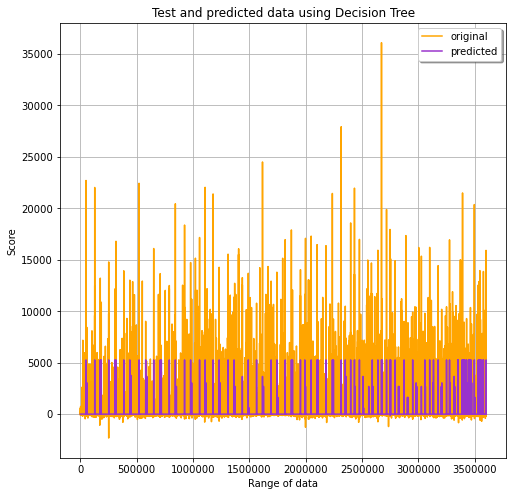

In [156]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(x_ax, y_orig,'orange', label="original")
plt.plot(x_ax, y_pred,'darkorchid' ,label="predicted")
plt.title("Test and predicted data using Decision Tree")
plt.xlabel('Range of data')
plt.ylabel('Score')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.ticklabel_format(style='plain',useOffset=False) 
plt.grid(True)
plt.show()  
 

### Question 2 : Predict Controversiality of the comment

#### ML Transformations

In [101]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import roc_curve, roc_auc_score
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [9]:
#Selecting necessary columns
df_con = df_full.select(['author_premium', 'controversiality', 'locked', 'no_follow', 'stickied','total_awards_received','comment_length','hour', 'score'] )

In [10]:
#Checking categorical columns
df_con.groupBy('author_premium').count().show()

22/04/29 15:35:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+--------+
|author_premium|   count|
+--------------+--------+
|          null| 2988543|
|          true|  763357|
|         false|14369052|
+--------------+--------+



In [11]:
#Keeping the rows with only True, False as author_premium
df_con = df_con.filter((df_con.author_premium == 'true') | (df_con.author_premium == 'false'))

In [12]:
#Checking the balance of target
df_con.groupBy('controversiality').count().show()

+----------------+--------+
|controversiality|   count|
+----------------+--------+
|               1|  779649|
|               0|14352760|
+----------------+--------+



In [13]:
#Downsamping as controversiality is imbalanced
major_df = df_con.filter(col("controversiality") == 0)
minor_df = df_con.filter(col("controversiality") == 1)
ratio = int(major_df.count()/minor_df.count())

In [14]:
sampled_majority_df = major_df.sample(False, 1/ratio)
downsampled_df = sampled_majority_df.unionAll(minor_df)

In [120]:
downsampled_df.groupBy('controversiality').count().show()

+----------------+------+
|controversiality| count|
+----------------+------+
|               1|779649|
|               0|799348|
+----------------+------+



In [61]:
#Splitting the data into train test and predict for our creating the model
train_data, test_data = downsampled_df.randomSplit([0.8, 0.2,], 24)

In [62]:
stringIndexer_hour = StringIndexer(inputCol="hour", outputCol="hour_idx")

In [63]:
onehot_hour = OneHotEncoder(inputCol="hour_idx", 
                       outputCol="hour_vec")

In [64]:
vectorAssembler_con = VectorAssembler(
    inputCols=['author_premium', 'locked', 'no_follow', 'stickied','total_awards_received','comment_length','hour_vec', 'score'],
    outputCol= "features")

#### Logistic Regression

In [83]:
# Create initial LogisticRegression model
lr2 = LogisticRegression(labelCol="controversiality", featuresCol="features")

In [84]:
#Creating a pipeline
pipeline_lr2 = Pipeline(stages=[stringIndexer_hour, onehot_hour, vectorAssembler_con, lr2])

In [93]:
# Create ParamGrid for Cross Validation
lrparamGrid2 = ParamGridBuilder()\
             .addGrid(lr2.regParam, [0.01, 0.1, 0.5])\
             .addGrid(lr2.elasticNetParam, [0.25, 0.5, 0.75])\
             .addGrid(lr2.maxIter, [5, 10, 20])\
             .build()

In [94]:
# Evaluate model
lrevaluator2 = BinaryClassificationEvaluator().setLabelCol("controversiality")

In [95]:
# Create 3-fold CrossValidator
lrcv2 = CrossValidator(estimator = pipeline_lr2,
                    estimatorParamMaps = lrparamGrid2,
                    evaluator = lrevaluator2,
                    numFolds = 3)

In [96]:
# Run cross validations
lrcvModel2 = lrcv2.fit(train_data)

In [183]:
# Save the model pipeline into s3
lrcvModel2.write().save('s3://ssp88-labdata2/lrcvModel2')

In [99]:
# Use test set here so we can measure the accuracy of our model on new data
lrprediction2 = lrcvModel2.transform(test_data)

In [127]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
lr_acc2 = lrevaluator2.evaluate(lrprediction2)

#Displaying the results
print("Accuracy = %g" % lr_acc2)
print("Test Error = %g" % (1.0 - lr_acc2))

Accuracy = 0.626823
Test Error = 0.373177


In [130]:
#Confusion Matrix 
#y_pred has the predicted labels
y_pred_lr=lrprediction2.select("prediction").collect()
#y_orig are the actual labels 
y_orig_lr =lrprediction2.select("controversiality").collect()

In [131]:
#Creating the confusion matrix 
cm = confusion_matrix(y_orig_lr, y_pred_lr)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 47209 111748]
 [ 28353 127511]]


#### Random Forest

In [111]:
# Create initial RandomForest model
rf2 = RandomForestClassifier(labelCol="controversiality", featuresCol="features")

In [112]:
#Creating a pipeline
pipeline_rf2 = Pipeline(stages=[stringIndexer_hour, onehot_hour, vectorAssembler_con, rf2])

In [114]:
# Create ParamGrid for Cross Validation
rfparamGrid2 = ParamGridBuilder()\
               .addGrid(rf2.maxDepth, [2, 5, 10])\
               .addGrid(rf2.maxBins, [5, 10, 20])\
               .addGrid(rf2.numTrees, [5, 20, 50])\
               .build()

In [119]:
# Evaluate model
rfevaluator2 = RegressionEvaluator().setLabelCol("controversiality")

In [122]:
# Create 3-fold CrossValidator
rfcv2 = CrossValidator(estimator = pipeline_rf2,
                      estimatorParamMaps = rfparamGrid2,
                      evaluator = rfevaluator2,
                      numFolds = 3)

In [123]:
# Run cross validations
rfcvModel2 = rfcv2.fit(train_data)

22/04/29 17:03:05 WARN CacheManager: Asked to cache already cached data.
22/04/29 17:03:05 WARN CacheManager: Asked to cache already cached data.
22/04/29 17:05:05 WARN DAGScheduler: Broadcasting large task binary with size 1335.8 KiB
22/04/29 17:05:07 WARN DAGScheduler: Broadcasting large task binary with size 1782.4 KiB
22/04/29 17:05:35 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
22/04/29 17:05:37 WARN DAGScheduler: Broadcasting large task binary with size 1402.0 KiB
22/04/29 17:05:39 WARN DAGScheduler: Broadcasting large task binary with size 1904.9 KiB
22/04/29 17:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1003.3 KiB
22/04/29 17:06:08 WARN DAGScheduler: Broadcasting large task binary with size 1413.0 KiB
22/04/29 17:06:10 WARN DAGScheduler: Broadcasting large task binary with size 1935.1 KiB
22/04/29 17:07:55 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
22/04/29 17:07:57 WARN DAGScheduler: Broadcasting lar

In [184]:
# Save the model pipeline into s3
rfcvModel2.write().save('s3://ssp88-labdata2/rfcvModel2')

In [124]:
# Use test set here so we can measure the accuracy of our model on new data
rfprediction2 = rfcvModel2.transform(test_data)

In [126]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
rf_acc2 = rfevaluator2.evaluate(rfprediction2)

#Displaying the results
print("Accuracy = %g" % rf_acc2)
print("Test Error = %g" % (1.0 - rf_acc2))

Accuracy = 0.550374
Test Error = 0.449626


In [132]:
#Confusion Matrix
#y_pred has the predicted labels
y_pred_rf=rfprediction2.select("prediction").collect()
#y_orig are the actual labels 
y_orig_rf =rfprediction2.select("controversiality").collect()

In [133]:
#Creating the confusion matrix 
cm = confusion_matrix(y_orig_rf, y_pred_rf)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[137319  21638]
 [ 73725  82139]]


### ROC Curve

In [161]:
from sklearn.metrics import roc_curve
from pyspark.ml.functions import vector_to_array

y_score_lr = lrprediction2.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_true_lr = lrprediction2.select("controversiality").rdd.keys().collect()
fprlr, tprlr, thresholdslr = roc_curve(y_true_lr, y_score_lr)

In [162]:
y_score_rf = rfprediction2.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_true_rf = rfprediction2.select("controversiality").rdd.keys().collect()
fprrf, tprrf, thresholdsrf = roc_curve(y_true_rf, y_score_rf)

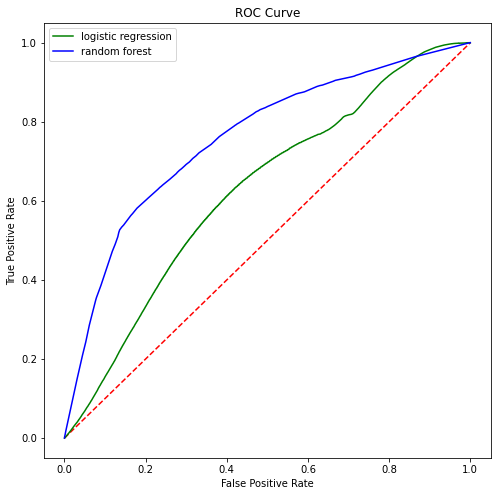

<Figure size 432x288 with 0 Axes>

In [179]:
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'r--')
lr_plot = plt.plot(fprlr,
         tprlr,'g', label='logistic regression')
rf_plot = plt.plot(fprrf,
         tprrf,'b', label='random forest')
plt.legend(loc="upper left")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.show()
plt.savefig('roc_lr.png')

In [ ]:
spark.stop()